# AutoEncoders

💡 Basic Purpose: A model that attempts to describe very large data with as few features as possible.

AutoEncoders have an **Encoder** and a **Decoder**.

1. The **Encoder** takes the input data and reduces it to a smaller, compressed representation called the **latent space**.

2. The **latent space** is a low-dimensional space that captures the essential features of the input data.

3. The **Decoder** then takes this compressed representation and tries to reconstruct the original data.


<p align="center">
    <img src="../showcase_images/autoEncoders.png" alt="auto encoder network" width="300">
</p>

- The **goal** is to make the reconstructed output as close to the original input as possible, while minimizing the reconstruction error.

**Latent Space**

The **number of neurons** in the latent space layer determines how many dimensions the Encoded data will be represented as.
-  In the above example we have 3 neurons so the **encoded data** will be represented in 3D space, if it were 5 it would be represented in 5D space.

*Latent Space Scatter Plot Example:*

<p align="center">
    <img src="../showcase_images/LatentSpaceRepresentation.png" alt="auto encoder network" width="500">
</p>

- Note the one image of a number 7 that is near the 0's cluster, because that point is in a region the decoder has learned to associate with the features of a "0", the reconstruction will likely be poor. The resulting image might look like a blurry "0", or an ambiguous shape that's a mix of a "7" and a "0".

**AutoEncoder Use-Cases:**
- Dimensionality Reduction
- Image Compression
- Image denoising
- Anomaly detection
- Feature extraction

**Limitations:**
- Overfitting: The model might simply just copy the input to the output without learning a meaningful compressed representation.
- Lack of Generative capability (VAE models are used for this purpose)
- Computational cost

**Other Notes:**
- Labels/targets are not necessary for a standard autoencoder. An autoencoder is an **unsupervised learning model**.

---

# Torch Implementation With MNIST Dataset

⭐️ The MNIST dataset was used in -> [../basic_NN_multi-class-classification.ipynb](../basic_NN_multi-class-classification.ipynb), review it for a more detailed explanation of MNIST. Note for this project we will use the torch MNIST.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set the device for training (GPU if available, otherwise CPU)
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(f"Using device: {DEVICE}")

Using device: mps


### Get The Dataset:

In [3]:
# Define a transform to convert images to tensors, and normalize them to be between [0, 1].
transform = transforms.ToTensor()

# Download and load the MNIST training and test datasets if it wasn't already downloaded, else load it.
train_dataset = datasets.MNIST(root='../datasets', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../datasets', train=False, download=True, transform=transform)

In [4]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

`train_dataset` contains 60000 images/labels. Each image is 28x28 pixels

In [6]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../datasets
    Split: Test
    StandardTransform
Transform: ToTensor()

### Plot An Image

In [7]:
first_image, first_label = train_dataset[0]
first_image.shape, first_label

(torch.Size([1, 28, 28]), 5)

The label for the first image is: 5


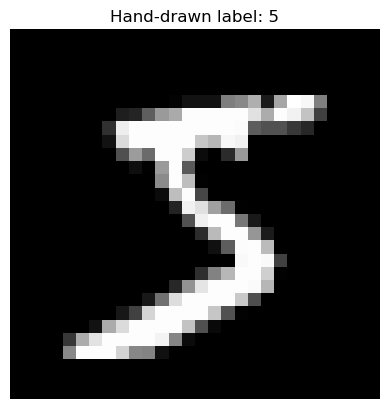

In [8]:
# Reshape to remove the channels dimension (1) -> (28, 28)
first_image = first_image.reshape(28, 28)
print(f"The label for the first image is: {first_label}")
plt.imshow(first_image, cmap="gray")
plt.title(f"Hand-drawn label: {first_label}")
plt.axis("off")  
plt.show()

### AutoEncoder Model

In [9]:
# Hyperparameters
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
LATENT_DIM = 16 # The number of neurons/size of the latent space layer.

In [10]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        """
        Implements an autoEncoder.

        Both the Encoder and Decoder have 3 layers each.

        Input: the MNIST dataset is labeled as [batch_size, 1, 28, 28]
            - Where 1 is the number of channels since this is grayscale it is 1, if it were RGB it would be 3.
            - 28x28 is each images height and width.
        """

        # Encoder: Converts input data into a compressed latent representation
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # outputs -> [16, 14, 14]
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # -> [32, 7, 7]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> [64, 4, 4]
            nn.ReLU(),
        )

        # Latent space: Flatten the output of the encoder
        self.flatten = nn.Flatten()
        self.fcn_encode = nn.Linear(64 * 4 * 4, LATENT_DIM)

        # Decoder: Reconstructs image from latent representation
        self.fcn_decode = nn.Linear(LATENT_DIM, 64 * 4 * 4)
        self.unflatten = nn.Unflatten(1, (64, 4, 4))
        self.decoder = nn.Sequential(
            # Input: is the latent representation [batch_size, 64, 4, 4]

            # ConvTranspose2d layers "upsample" or expand the tensor's spatial dimensions. 
            nn.ConvTranspose2d(
                64, 32, kernel_size=3, stride=2, padding=1
            ),  # -> [32, 7, 7]
            nn.ReLU(),
            nn.ConvTranspose2d(
                32, 16, kernel_size=3, stride=2, padding=1, output_padding=1
            ),  # -> [16, 14, 14]
            nn.ReLU(),
            nn.ConvTranspose2d(
                16, 1, kernel_size=3, stride=2, padding=1, output_padding=1
            ),  # -> [1, 28, 28]
            nn.Sigmoid(),
        )

    def forward(self, x):
        """Train"""
        encoded = self.encoder(x)
        flattened = self.flatten(encoded)
        latent = self.fcn_encode(flattened)

        decoded_flattened = self.fcn_decode(latent)
        decoded = self.unflatten(decoded_flattened)
        reconstructed = self.decoder(decoded)
        return reconstructed

    def encode(self, x):
        """
        Provides direct access to the compressed, learned representation of the data, which is useful for tasks beyond simple reconstruction, like plotting scatter plots.
        """
        encoded = self.encoder(x)
        flattened = self.flatten(encoded)
        latent = self.fcn_encode(flattened)
        return latent

`Initialize`

In [12]:
model = AutoEncoder().to(DEVICE)
criterion = nn.MSELoss() # Mean Squared Error is a common loss function for autoencoders
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

`Train`

In [13]:
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            images, _ = data
            images = images.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            train_loss = criterion(outputs, images) # Compare the outputs directly with the images.

            train_loss.backward()
            optimizer.step()

            running_loss += train_loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

In [14]:
train(model, train_loader, criterion, optimizer, epochs=EPOCHS)

Epoch [1/10], Loss: 0.0375
Epoch [2/10], Loss: 0.0140
Epoch [3/10], Loss: 0.0122
Epoch [4/10], Loss: 0.0112
Epoch [5/10], Loss: 0.0106
Epoch [6/10], Loss: 0.0102
Epoch [7/10], Loss: 0.0098
Epoch [8/10], Loss: 0.0096
Epoch [9/10], Loss: 0.0094
Epoch [10/10], Loss: 0.0092


### Visualize

`Decoder Reconstruction`

In [15]:
def visualize_reconstructions(model, test_loader, num_images=10):
    """Plot the original and reconstructed images from the test dataset"""
    model.eval() # set model to evaluation mode
    with torch.no_grad():
        dataiter = iter(test_loader)
        images, _ = next(dataiter)
        images = images.to(DEVICE)
        
        reconstructed_images = model(images).cpu().numpy()
        original_images = images.cpu().numpy()
        
        plt.figure(figsize=(15, 2))
        for i in range(num_images):
            # Original Images
            ax = plt.subplot(2, num_images, i + 1)
            plt.imshow(original_images[i].squeeze(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == 0:
                ax.set_title('Originals:')

            # Reconstructed Images
            ax = plt.subplot(2, num_images, i + 1 + num_images)
            plt.imshow(reconstructed_images[i].squeeze(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == 0:
                ax.set_title('Reconstructions:')
        plt.show()

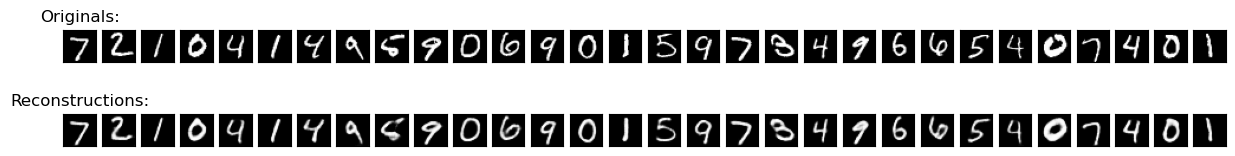

In [20]:
visualize_reconstructions(model, test_loader, num_images=30)

`Latent Space`

- A 2D scatter plot where each point is an image, and its coordinates are determined by two of the dimensions from its latent representation.

- Note that we set **LATENT_DIM = 16**. To visualize this 16-dimensional space, we will create a 2D plot using the first two dimensions of the sixteen as its axes.

- The models performance is determined by how well it clusters the same numbers together.


In [17]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_latent_space(model, data_loader):
    model.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for images, l in data_loader:
            images = images.to(DEVICE)

            latents = model.encode(images)
            latent_vectors.append(latents.cpu().numpy())
            labels.append(l.numpy())

    latent_vectors = np.concatenate(latent_vectors)
    labels = np.concatenate(labels)

    plt.figure(figsize=(10, 8))
    
    # Create a scatter plot of the first two latent dimensions
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', alpha=0.7)
    
    plt.title('Latent Space Visualization (First 2 Dimensions)')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    
    # Add a colorbar to show which color corresponds to which digit
    plt.colorbar(scatter, ticks=range(10), label='Digit Label')
    plt.show()

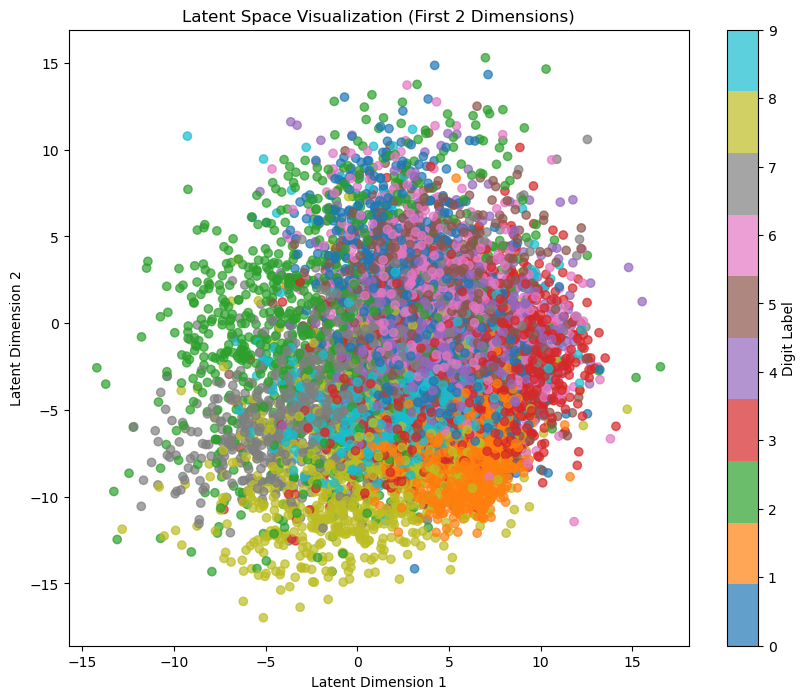

In [18]:
visualize_latent_space(model, test_loader)